## Enviroment Setup

In [ ]:
!pip install alibi-detect

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

from alibi_detect.od import IForest
from alibi_detect.datasets import fetch_kdd
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_roc

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Set path to read pre-trained model

In [ ]:
filepath = "/content/drive/My Drive/Colab Notebooks/IPRAD/alibi-detect/pre-trained/od_if_kddcup/"

## Dataset
The outlier detector needs to detect computer network intrusions using TCP dump data for a local-area network (LAN) simulating a typical U.S. Air Force LAN. A connection is a sequence of TCP packets starting and ending at some well defined times, between which data flows to and from a source IP address to a target IP address under some well defined protocol. Each connection is labeled as either normal, or as an attack.

There are 4 types of attacks in the dataset:

* DOS: denial-of-service, e.g. syn flood;
* R2L: unauthorized access from a remote machine, e.g. guessing password;
* U2R: unauthorized access to local superuser (root) privileges;
* probing: surveillance and other probing, e.g., port scanning.

The dataset contains about 5 million connection records.

There are 3 types of features:

* basic features of individual connections, e.g. duration of connection
* content features within a connection, e.g. number of failed log in attempts
* traffic features within a 2 second window, e.g. number of connections to the same host as the current connection

### Load dataset
We only keep a number of continuous (18 out of 41) features.

In [ ]:
kddcup = fetch_kdd(percent10=True)  # only load 10% of the dataset
print(kddcup.data.shape, kddcup.target.shape)

(494021, 18) (494021,)


In [ ]:
df = pd.DataFrame(data=kddcup.data)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,8,0,0,0,0,1,0,0,9,9,1,0,0.11,0,0,0,0,0
1,8,0,0,0,0,1,0,0,19,19,1,0,0.05,0,0,0,0,0
2,8,0,0,0,0,1,0,0,29,29,1,0,0.03,0,0,0,0,0
3,6,0,0,0,0,1,0,0,39,39,1,0,0.03,0,0,0,0,0
4,6,0,0,0,0,1,0,0,49,49,1,0,0.02,0,0,0,0,0


Assume that a model is trained on normal instances of the dataset (not outliers) and standardization is applied:

In [ ]:
np.random.seed(0)
normal_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=400000, perc_outlier=0)
X_train, y_train = normal_batch.data.astype('float'), normal_batch.target
print(X_train.shape, y_train.shape)
print('{}% outliers'.format(100 * y_train.mean()))

(400000, 18) (400000,)
0.0% outliers


In [ ]:
mean, stdev = X_train.mean(axis=0), X_train.std(axis=0)

Apply standardization:

In [ ]:
X_train = (X_train - mean) / stdev

### Load or define outlier detector

The pretrained outlier and adversarial detectors used in the exercise can be found [here](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect). You can use the built-in fetch_detector function which saves the pre-trained models in a local directory filepath and loads the detector. Alternatively, you can train a detector from scratch:

In [ ]:
load_outlier_detector = True

In [ ]:
#filepath = 'my_path'  # change to directory where model is downloaded
if load_outlier_detector:  # load pretrained outlier detector
    detector_type = 'outlier'
    dataset = 'kddcup'
    detector_name = 'IForest'
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
    filepath = os.path.join(filepath, detector_name)
else:  # define model, initialize, train and save outlier detector

    # initialize outlier detector
    od = IForest(threshold=None,  # threshold for outlier score
                 n_estimators=100)

    # train
    od.fit(X_train)

    # save the trained outlier detector
    save_detector(od, filepath)

Directory /content/drive/My Drive/Colab Notebooks/IPRAD/alibi-detect/pre-trained/od_if_kddcup/IForest does not exist and is now created.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.ensemble.iforest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning:

Trying to unpickle estimator ExtraTreeRegressor from version 0.21.

If **load_outlier_detector** equals False, the warning tells us we still need to set the outlier threshold. This can be done with the **infer_threshold** method. We need to pass a batch of instances and specify what percentage of those we consider to be normal via **threshold_perc**. Let’s assume we have some data which we know contains around 5% outliers. The percentage of outliers can be set with perc_outlier in the **create_outlier_batch** function.

In [ ]:
print(filepath)

/content/drive/My Drive/Colab Notebooks/IPRAD/alibi-detect/pre-trained/od_if_kddcup/IForest


In [ ]:
np.random.seed(0)
perc_outlier = 5
threshold_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=perc_outlier)
X_threshold, y_threshold = threshold_batch.data.astype('float'), threshold_batch.target
X_threshold = (X_threshold - mean) / stdev
print('{}% outliers'.format(100 * y_threshold.mean()))

5.0% outliers


In [ ]:
od.infer_threshold(X_threshold, threshold_perc=100-perc_outlier)
print('New threshold: {}'.format(od.threshold))

New threshold: 0.08008174509752322


Let’s save the outlier detector with updated threshold:

In [ ]:
save_detector(od, filepath)

## Detect outliers

We now generate a batch of data with 10% outliers and detect the outliers in the batch.

In [ ]:
np.random.seed(1)
outlier_batch = create_outlier_batch(kddcup.data, kddcup.target, n_samples=1000, perc_outlier=10)
X_outlier, y_outlier = outlier_batch.data.astype('float'), outlier_batch.target
X_outlier = (X_outlier - mean) / stdev
print(X_outlier.shape, y_outlier.shape)
print('{}% outliers'.format(100 * y_outlier.mean()))

(1000, 18) (1000,)
10.0% outliers


Predict outliers:

In [ ]:
od_preds = od.predict(X_outlier, return_instance_score=True)

## Display results

F1 score and confusion matrix:

F1 score: 0.3315


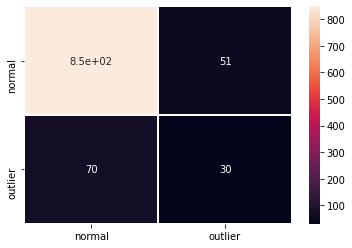

In [ ]:
labels = outlier_batch.target_names
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
print('F1 score: {:.4f}'.format(f1))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

Plot instance level outlier scores vs. the outlier threshold:

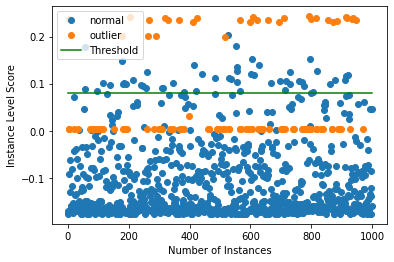

In [ ]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold)

We can see that the isolation forest does not do a good job at detecting 1 type of outliers with an outlier score around 0. This makes inferring a good threshold without explicit knowledge about the outliers hard. Setting the threshold just below 0 would lead to significantly better detector performance for the outliers in the dataset. This is also reflected by the ROC curve:

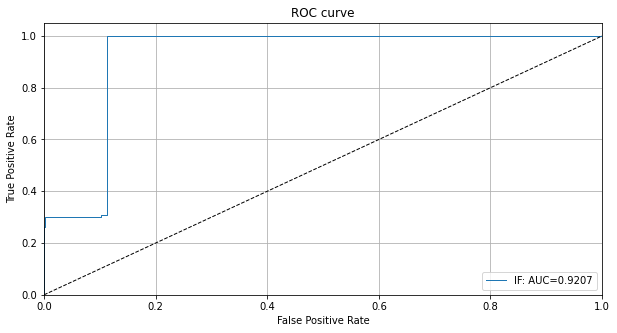

In [ ]:
roc_data = {'IF': {'scores': od_preds['data']['instance_score'], 'labels': y_outlier}}
plot_roc(roc_data)